In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='190GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=177G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.98:46512 --name dummy-name --nthreads 36 --memory-limit 176.95GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.98:46512,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


2025-04-09 13:52:42,013 - distributed.scheduler - ERROR - Couldn't gather keys: {('all-aggregate-e5ba0812aba78ad09ebec59d80787bb1',): 'waiting'}


### Load in data

In [6]:
# Key water mass transformation budget terms

budget_terms = ['Eulerian_tendency', 'advection', 'diffusion', 
            'boundary_fluxes', 'convergent_mass_transport', 
           'mass_tendency', 'mass_source', 'spurious_numerical_mixing', 
           "surface_exchange_flux", "bottom_flux", "frazil_ice", 
            "surface_ocean_flux_advective_negative_rhs"]

other_budget_terms = ["surface_ocean_flux_advective_negative_rhs_heat", 
                     "surface_ocean_flux_advective_negative_rhs_salt", 
                     "surface_exchange_flux_heat", 
                     "surface_exchange_flux_salt", 
                     "frazil_ice_heat", 
                     "bottom_flux_heat",
                     "boundary_fluxes", 
                     "mass_tendency", 
                     "diffusion_heat", 
                     "diffusion_salt",
                     "spurious_numerical_mixing",
                     "convergent_mass_transport"]
budget_terms= sorted(list(set(budget_terms) | set(other_budget_terms)))

In [7]:
decomp_budget_terms = ["surface_exchange_flux_advective_evaporation_salt", 
                    "surface_exchange_flux_advective_rain_and_ice_salt",
                    "surface_exchange_flux_advective_snow_salt",
                    "surface_exchange_flux_advective_rivers_salt", 
                    "surface_exchange_flux_advective_icebergs_salt",
                    "surface_exchange_flux_advective_virtual_precip_restoring_salt",
                    "surface_exchange_flux_advective_sea_ice_salt",
                    "surface_exchange_flux_nonadvective_longwave_heat", 
                    "surface_exchange_flux_nonadvective_shortwave_heat",
                    "surface_exchange_flux_nonadvective_sensible_heat",
                    "surface_exchange_flux_nonadvective_latent_heat", 
                    "surface_exchange_flux_advective_mass_transfer_heat"]

In [8]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)

wmts = []

for (t, file) in enumerate(datafiles): 
    print(file)
    ds = xr.open_mfdataset(
        file,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    ds = ds.fillna(0.)

    grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
    grid._ds = grid._ds.assign_coords({
        "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
        "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
    })
    grid = xwmt.add_gridcoords(
        grid,
        {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
        {"Z_target": "extend"}
    )

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
    
        # budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
        budgets_dict = xbudget.load_yaml(datadir("../../MOM6_AABW.yaml"))

        xbudget.collect_budgets(grid, budgets_dict)
        
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict
        ) #if region not passed, the whole globe is taken
        wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                        integrate=True, along_section=False)
        
        wmt = wmb.wmt[budget_terms].compute()
        wmt = wmt.assign_coords({"sigma2_i_target": wmb.wmt["sigma2_i_target"].compute()})

        wmb_decomp = xwmb.WaterMassBudget(
                grid,
                budgets_dict, 
                decompose=["surface_exchange_flux", "nonadvective", "advective"]
                ) #if region not passed, the whole globe is taken
        wmb_decomp.mass_budget("sigma2", greater_than=True, default_bins=False, 
                        integrate=True, along_section=False)
        wmt_decomp = wmb_decomp.wmt[decomp_budget_terms].compute()
        wmt_decomp = wmt_decomp.assign_coords({"sigma2_i_target": wmb_decomp.wmt["sigma2_i_target"].compute()})

        
        wmts += [1 * xr.merge(1 * [wmt_decomp, wmt])]

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1850-1854.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1855-1859.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1860-1864.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1865-1869.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1870-1874.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1875-1879.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1880-1884.zarr
/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2/CM4Xp125_budgets_sigma2_1885-1889.zarr
/vortexfs1/home/

In [9]:
wmts_ds = xr.concat(wmts, dim = "time")
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
wmts_ds.to_netcdf(savedir + "Global_WMT_Budget.nc")

In [38]:
wmts_ds["surface_boundary_fluxes"] = wmts_ds["boundary_fluxes"] - wmts_ds["bottom_flux"]

<xarray.DataArray 'sigma2_l_target' ()> Size: 8B
array(36.75525)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 36.76
    exp              <U7 28B 'control'
Attributes:
    axis:          Z
    cell_methods:  sigma2_l:point
    edges:         sigma2_i
    long_name:     Target Potential Density minus 1000 kg/m3 at cell center
    positive:      down
    units:         kg m-3

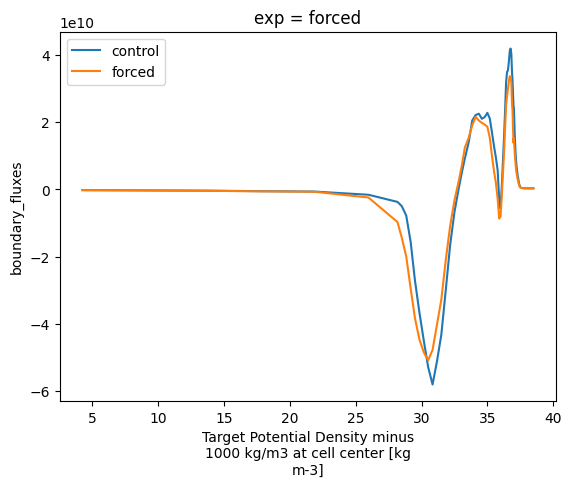

In [39]:
wmts_ds.boundary_fluxes.sel(exp = "control").mean("time").plot(label = "control")
wmts_ds.boundary_fluxes.sel(exp = "forced").mean("time").plot(label = "forced")

max_idx = wmts_ds.boundary_fluxes.sel(exp = "control").mean("time").argmax()
plt.legend()
wmts_ds.sigma2_l_target[max_idx]


<xarray.DataArray 'sigma2_l_target' ()> Size: 8B
array(36.75525)
Coordinates:
    rho2_l           float64 8B 1.037e+03
    sigma2_l_target  float64 8B 36.76
    exp              <U7 28B 'control'
Attributes:
    axis:          Z
    cell_methods:  sigma2_l:point
    edges:         sigma2_i
    long_name:     Target Potential Density minus 1000 kg/m3 at cell center
    positive:      down
    units:         kg m-3

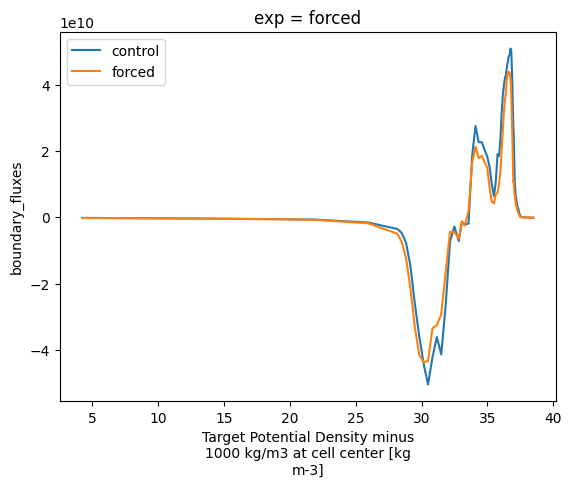

In [42]:
wmts_ds.boundary_fluxes.sel(exp = "control").median("time").plot(label = "control")
wmts_ds.boundary_fluxes.sel(exp = "forced").median("time").plot(label = "forced")

max_idx = wmts_ds.boundary_fluxes.sel(exp = "control").median("time").argmax()
plt.legend()
wmts_ds.sigma2_l_target[max_idx]
